# Extracting FUCCI calibration data (reference traces)

This notebook demonstrates how to **extract calibration time-courses** from raw FUCCI movies
(e.g. TrackMate XML + matching image files) to generate reference traces that can be used for
sensor construction.

**You will learn to:**
- Load TrackMate-linked trajectories from `.xml` tracking files
- Extract per-cell fluorescence curves for FUCCI channels
- Pre-process, normalise and filter calibration tracks
- Export reference traces for use in `sensor_calibration.ipynb`

**When to use this notebook**
Use this notebook *before* building a sensor. If you have raw FUCCI movies and want to
extract ground-truth time-courses for G1/S/G2-M marker evolution, this is the first step.

**Input expected**


|   File type   |                     Example path                           |
|---------------|------------------------------------------------------------|
| TrackMate XML | `examples/reproducibility/inputs/merged_linked.ome.xml`    |
| TIFF/OME-TIFF | `examples/reproducibility/inputs/downscaled_hacat.ome.tif` |


**Output**
A CSV reference like: `examples/example_data/hacat_fucciphase_reference.csv`

In [37]:
import glob
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fucciphase import process_trackmate
from fucciphase.plot import plot_raw_intensities
from fucciphase.sensor import get_fuccisa_default_sensor

In [38]:
import os
from pprint import pprint

print(glob.glob("*.tif"))
print(glob.glob("*.ome.tif"))
print(glob.glob("*.xml"))
print(glob.glob("inputs/*"))


['downscaled_hacat.ome.tif', 'labels.tif']
['downscaled_hacat.ome.tif']
['merged_linked.ome.xml', 'merged_linked.ome_processed.xml', 'merged_linked.ome_processed_processed.xml', 'merged_linked.ome_processed_processed_processed.xml']
[]


## Read all TrackMate outputs

* Multiple videos were processed are saved as XML files
* The XML files should follow a template naming scheme so that it can be identified

In [39]:
template_file = "*.xml"
track_files = glob.glob(template_file)
print(track_files)

['merged_linked.ome.xml', 'merged_linked.ome_processed.xml', 'merged_linked.ome_processed_processed.xml', 'merged_linked.ome_processed_processed_processed.xml']


# General information

Pass information about the channel names

In [40]:
cyan_channel = "MEAN_INTENSITY_CH2"
magenta_channel = "MEAN_INTENSITY_CH1"
default_sensor = get_fuccisa_default_sensor()
regex = r"Track_[0-9]+\.[a-z]+"
timestep = 0.25  # in hours
max_n_frames = 0

# Extract full tracks
Obtain tracks that go from cell division to cell division.

merged_linked.ome.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)
C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\sensor.py:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(arg))


Track ID:  11


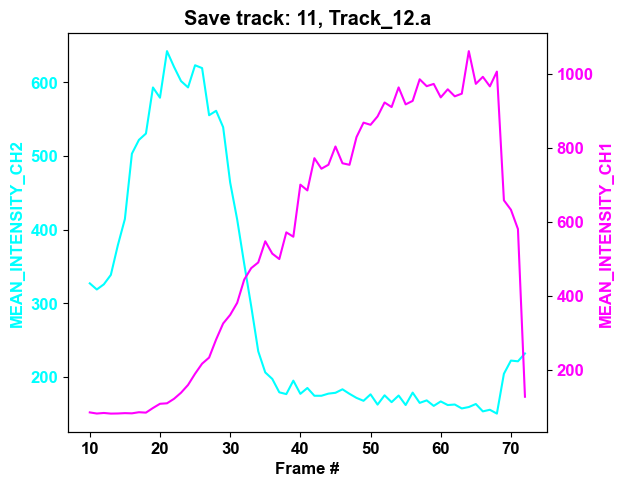

Track ID:  20
Track ID:  17


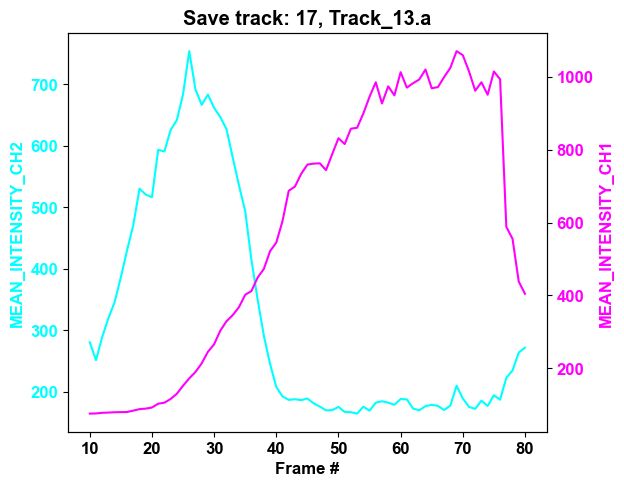

Track ID:  14


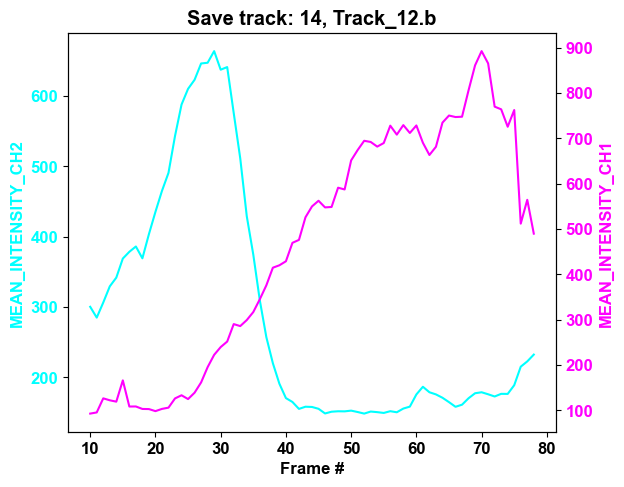

merged_linked.ome_processed.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)
C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\sensor.py:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(arg))


Track ID:  11.0


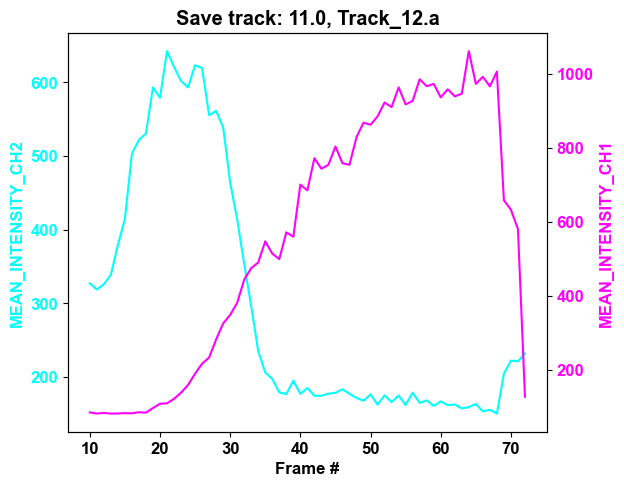

Track ID:  20.0
Track ID:  17.0


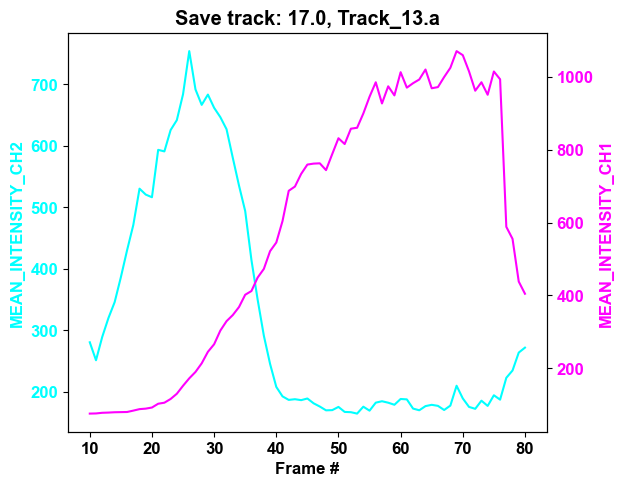

Track ID:  14.0


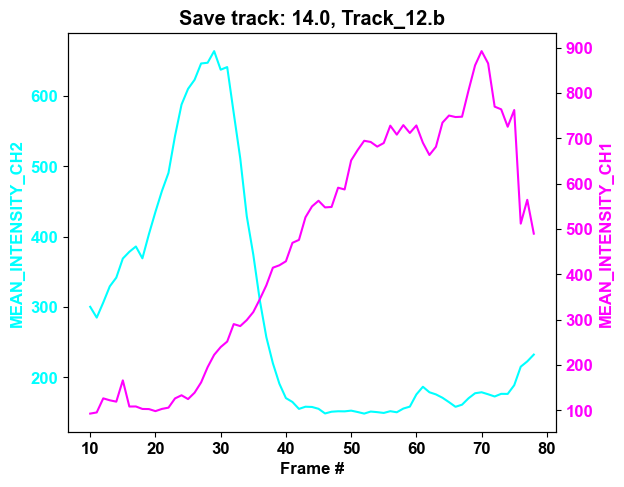

merged_linked.ome_processed_processed.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)
C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\sensor.py:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(arg))


Track ID:  11.0


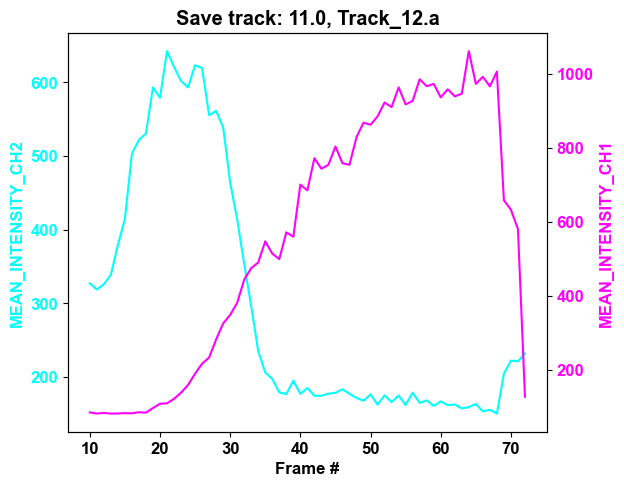

Track ID:  20.0
Track ID:  17.0


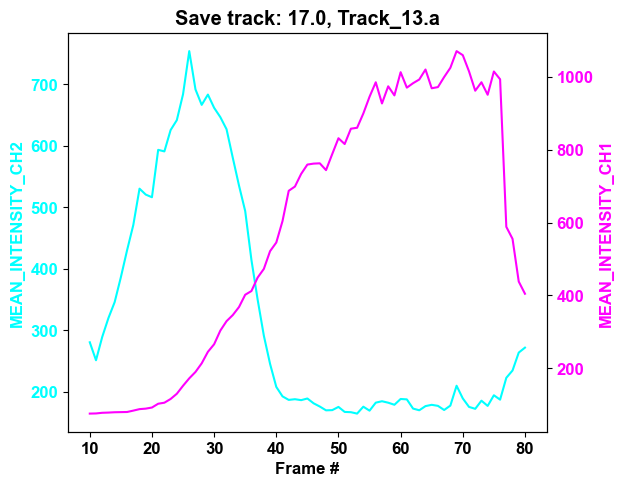

Track ID:  14.0


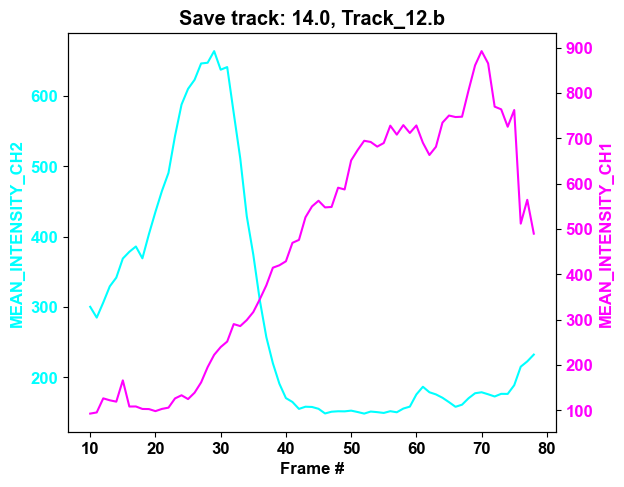

merged_linked.ome_processed_processed_processed.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)
C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\sensor.py:15: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(arg))


Track ID:  11.0


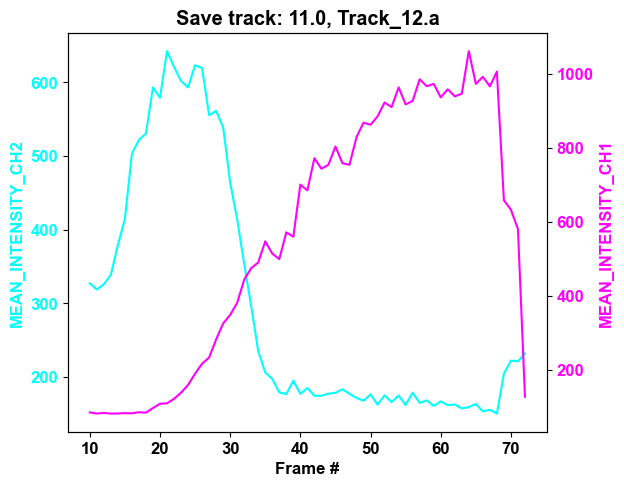

Track ID:  20.0
Track ID:  17.0


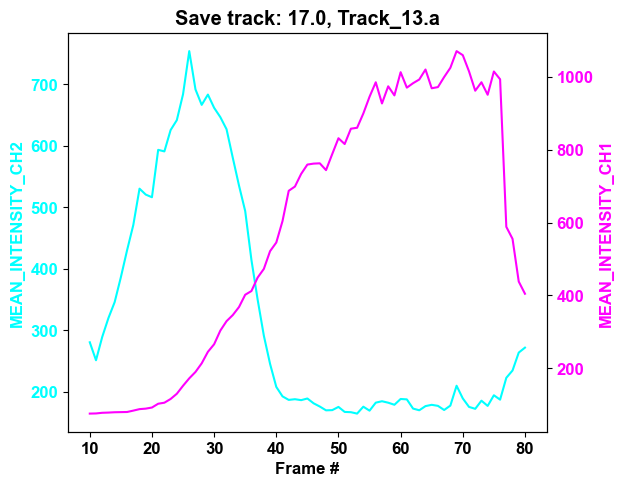

Track ID:  14.0


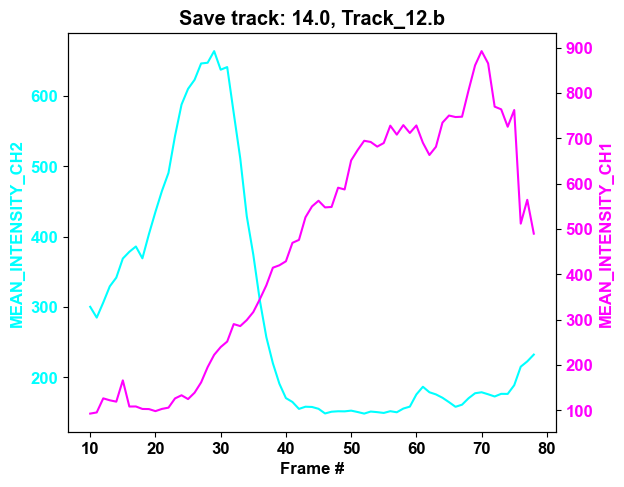

In [41]:
# tracks followed by another branch
dfs_save_tracks = []
# tracks that are not followed by another branch
dfs_candidate_tracks = []
for track_file in track_files:
    print(track_file)
    df = process_trackmate(
        track_file,
        channels=[cyan_channel, magenta_channel],
        sensor=default_sensor,
        thresholds=[0.1, 0.1],
        generate_unique_tracks=True,
    )
    all_names = df["name"].unique()
    candidate_tracks = []
    track_ids = df["UNIQUE_TRACK_ID"].unique()
    for track_id in track_ids:
        track = df[df["UNIQUE_TRACK_ID"] == track_id]
        name = track["name"].iloc[0]
        last_frame = track["FRAME"].max()
        # is the track a subtrack
        match = re.match(regex, name)
        # is there a subtrack
        next_match = any(df["name"].str.match(name + "[a-z]+").unique())
        if match is not None and last_frame < df["FRAME"].max():
            print("Track ID: ", track_id)
            if next_match:
                level_last_value = (
                    track[magenta_channel].iloc[-1] - track[magenta_channel].min()
                ) / (track[magenta_channel].max() - track[magenta_channel].min())
                if level_last_value > 0.5:
                    continue
                dfs_save_tracks.append(track[["FRAME", cyan_channel, magenta_channel]])
                title = f"Save track: {track_id}, {name}"
                max_n_frames = max(
                    max_n_frames, track["FRAME"].iloc[-1] - track["FRAME"].iloc[0]
                )
            else:
                if len(track) > 40:
                    dfs_candidate_tracks.append(
                        track[["FRAME", cyan_channel, magenta_channel]]
                    )
                    title = f"Candidate track: {track_id}, {name}"
                    max_n_frames = max(
                        max_n_frames, track["FRAME"].iloc[-1] - track["FRAME"].iloc[0]
                    )

                else:
                    continue

            plot_raw_intensities(track, channel1=cyan_channel, channel2=magenta_channel)
            plt.title(title)
            plt.show()

# Accept all candidate tracks

In [32]:
dfs_save_tracks.extend(dfs_candidate_tracks)
print(f"Selected {len(dfs_save_tracks)} tracks to process")

Selected 6 tracks to process


# Interpolate from time to percentages

In [33]:
percentages = np.linspace(0, 100, num=101)
cyan_interp = []
magenta_interp = []
average_time = 0
counter = 0
for track_df in dfs_save_tracks:
    track_cyan = track_df[cyan_channel]
    track_magenta = track_df[magenta_channel]
    time = timestep * (track_df["FRAME"] - track_df["FRAME"].min())
    average_time += time.max()
    # convert time to percentage
    time = 100.0 * time / time.iloc[-1]
    time = time.to_numpy()
    cyan_interp.append(np.interp(percentages, time, track_cyan))
    magenta_interp.append(np.interp(percentages, time, track_magenta))
    counter += 1

average_time /= counter
print("Average duration of cell cycle: ", average_time)

Average duration of cell cycle:  16.666666666666668


# Interpolate all curves

Interpolate curves to percentage scale and normalise curves

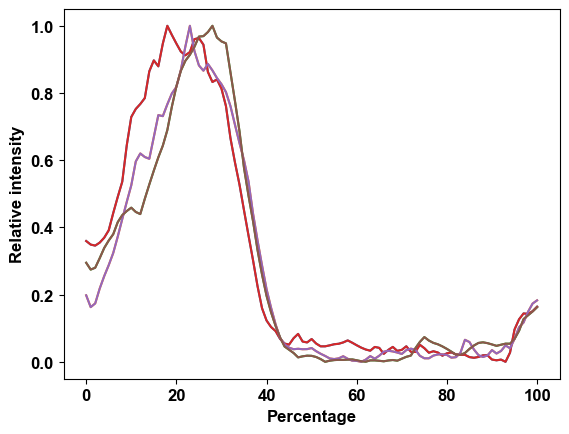

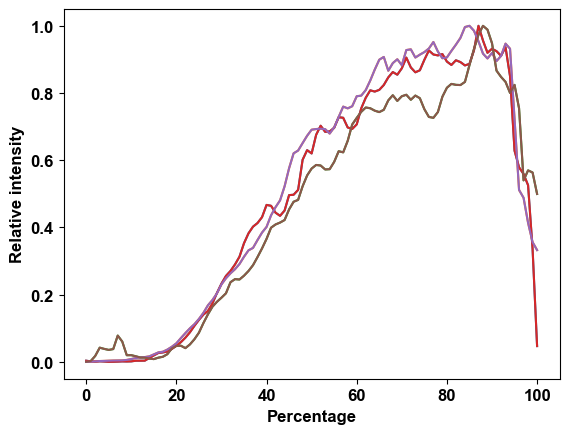

In [34]:
cyan_interp = np.array(cyan_interp)
magenta_interp = np.array(magenta_interp)
cyan_normal = np.zeros(shape=cyan_interp.shape)
magenta_normal = np.zeros(shape=magenta_interp.shape)


for idx, cyan_curve in enumerate(cyan_interp):
    cyan_curve_shifted = cyan_curve - cyan_curve.min()
    cyan_normal[idx] = cyan_curve_shifted / cyan_curve_shifted.max()
    plt.plot(percentages, cyan_normal[idx])
plt.xlabel("Percentage")
plt.ylabel("Relative intensity")
plt.show()

for idx, magenta_curve in enumerate(magenta_interp):
    magenta_curve_shifted = magenta_curve - magenta_curve.min()
    magenta_normal[idx] = magenta_curve_shifted / magenta_curve_shifted.max()
    plt.plot(percentages, magenta_normal[idx])
plt.xlabel("Percentage")
plt.ylabel("Relative intensity")

plt.show()

# Plot the average curve

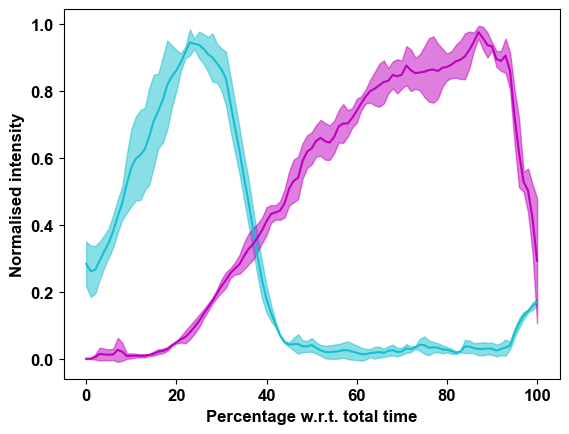

In [35]:
color = "tab:cyan"
color2 = "m"  # magenta

cyan_mean = cyan_normal.mean(axis=0)
cyan_std = cyan_normal.std(axis=0)

magenta_mean = magenta_normal.mean(axis=0)
magenta_std = magenta_normal.std(axis=0)

plt.plot(percentages, cyan_mean, color=color)
plt.fill_between(
    percentages, cyan_mean - cyan_std, cyan_mean + cyan_std, alpha=0.5, color=color
)
plt.plot(percentages, magenta_mean, color=color2)
plt.fill_between(
    percentages,
    magenta_mean - magenta_std,
    magenta_mean + magenta_std,
    alpha=0.5,
    color=color2,
)
plt.xlabel("Percentage w.r.t. total time")
plt.ylabel("Normalised intensity")
plt.savefig("average_intensities_hacat.png")
plt.savefig("average_intensities_hacat.pdf")
plt.savefig("average_intensities_hacat.svg")
plt.show()

In [36]:
export_df = pd.DataFrame(
    {
        "percentage": percentages,
        "time": percentages * average_time / 100.0,
        "cyan": cyan_mean,
        "magenta": magenta_mean,
    }
)
export_df.to_csv("hacat_fucciphase_reference.csv", index=False)